In [456]:
import pandas as pd
from pandas_datareader import data
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [457]:
# stock_data = data.DataReader('AAPL', start = '1/1/2010')
stock_data = pd.read_csv(os.getcwd() + "/Stock_Data/TSLA.csv")
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.sort_values(by='Date')
stock_data = stock_data.dropna()
stock_data['Outlier'] = 0
stock_data['Prediction'] = 0
stock_data.info()
stock_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 9 columns):
Date          2324 non-null datetime64[ns]
Open          2324 non-null float64
High          2324 non-null float64
Low           2324 non-null float64
Close         2324 non-null float64
Adj Close     2324 non-null float64
Volume        2324 non-null int64
Outlier       2324 non-null int64
Prediction    2324 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 181.6 KB


,Open,High,Low,Close,Adj Close,Volume,Outlier,Prediction
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2.324000e+03,2324.0,2324.0
mean,179.103275,182.202904,175.816979,179.099368,179.099368,5.318146e+06,0.0,0.0
std,113.302123,115.044299,111.427284,113.306670,113.306670,4.659933e+06,0.0,0.0
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05,0.0,0.0
25%,33.842498,34.487502,33.184999,33.817500,33.817500,1.761525e+06,0.0,0.0
50%,209.219993,213.149994,206.025002,208.705001,208.705001,4.414150e+06,0.0,0.0
75%,260.759995,264.497505,255.734997,260.789993,260.789993,7.130325e+06,0.0,0.0
max,386.690002,389.609985,379.350006,385.000000,385.000000,3.716390e+07,0.0,0.0


In [458]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Outlier,Prediction
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,0,0
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,0,0
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,0,0
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,0,0
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,0,0


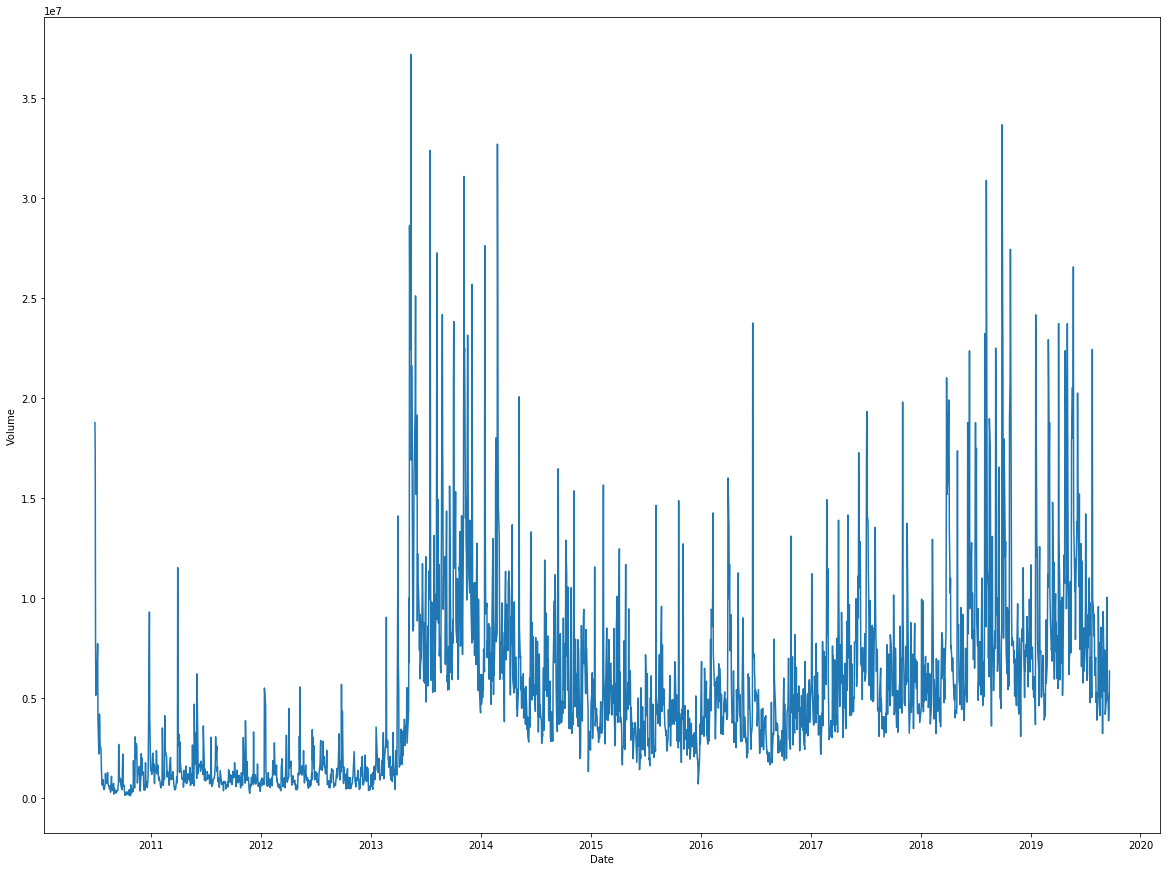

In [459]:
plt.figure(figsize=(20,15))
sns.lineplot(x = 'Date', y = 'Volume', data = stock_data)
plt.show()

# The stochastic oscillator is calculated using the following formula:

%K = 100(C – L14)/(H14 – L14)

Where:

C = the most recent closing price

L14 = the low of the 14 previous trading sessions

H14 = the highest price traded during the same 14-day period

%K= the current market rate for the currency pair

%D = 3-period moving average of %K

In [460]:
def create_stochastic_oscillator(stock_data):
    stock_data['L14'] = stock_data['Low'].rolling(window=14).min()
    stock_data['H14'] = stock_data['High'].rolling(window=14).max()
    stock_data['%K'] = 100*((stock_data['Close'] - stock_data['L14']) / (stock_data['H14'] - stock_data['L14']))
    stock_data['%D'] = stock_data['%K'].rolling(window=3).mean()
    return stock_data

In [463]:
def draw_stochastic_oscillator(stock_data):
    fig, axes = plt.subplots(figsize=(20,10))   
    stock_data[['%K','%D']].plot(ax=axes); axes.set_title('Oscillator')
    plt.show()

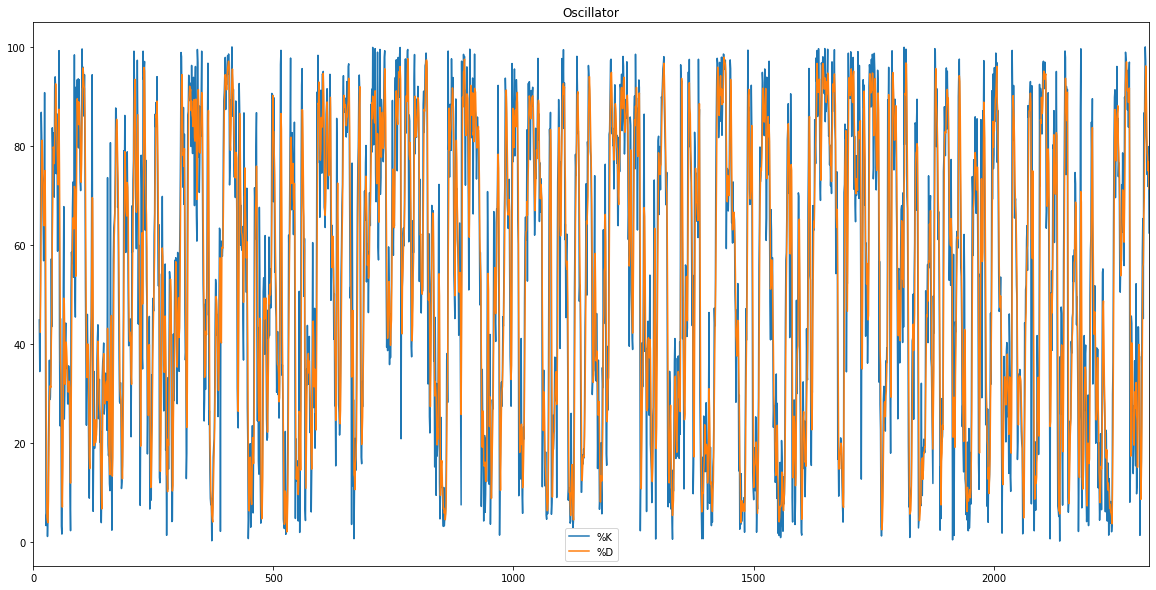

In [464]:
stock_data = create_stochastic_oscillator(stock_data)
draw_stochastic_oscillator(stock_data)

In [ ]:
# Create a column showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
# A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)

#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
stock_data['Sell Exit'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) 

#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
stock_data['Short'] = np.nan 
stock_data.loc[stock_data['Sell Entry'],'Short'] = -1 
stock_data.loc[stock_data['Sell Exit'],'Short'] = 0 


#Set initial position on day 1 to flat 
stock_data['Short'][0] = 0 

#Forward fill the position column to represent the holding of positions through time 
stock_data['Short'] = stock_data['Short'].fillna(method='pad') 

#Create a column in stock_data showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20) 

#Create a column in stock_data showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
stock_data['Buy Exit'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) 


#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
stock_data['Long'] = np.nan  
stock_data.loc[stock_data['Buy Entry'],'Long'] = 1  
stock_data.loc[stock_data['Buy Exit'],'Long'] = 0

#Set initial position on day 1 to flat 
stock_data['Long'][0] = 0  

#Forward fill the position column to represent the holding of positions through time 
stock_data['Long'] = stock_data['Long'].fillna(method='pad') 

#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
stock_data['Position'] = stock_data['Long'] + stock_data['Short']

In [ ]:
stock_data['Position'].plot(figsize=(20,10))

In [ ]:
#Set up a column holding the daily Tesla returns
stock_data['Market Returns'] = stock_data['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)

#Finally plot the strategy returns versus Apple returns
stock_data[['Strategy Returns','Market Returns']].cumsum().plot()

In [ ]:
stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)
stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20)
#Create empty "Position" column
stock_data['Position'] = np.nan 
#Set position to -1 for sell signals
stock_data.loc[stock_data['Sell Entry'],'Position'] = -1 
#Set position to -1 for buy signals
stock_data.loc[stock_data['Buy Entry'],'Position'] = 1 
#Set starting position to flat (i.e. 0)
stock_data['Position'].iloc[0] = 0 
#Forward fill the position column to show holding of positions through time
stock_data['Position'] = stock_data['Position'].fillna(method='ffill')
#Set up a column holding the daily Apple returns
stock_data['Market Returns'] = stock_data['Close'].pct_change()
#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)
#Finally plot the strategy returns versus Apple returns
stock_data[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10))

In [ ]:
stock_data.columns

In [ ]:
li = [stock_data.iloc[99].Volume]
def make_predictions(stock_data):
    vol_avg = int(np.mean(stock_data.iloc[:100].Volume))
    for i in range(100, len(stock_data)):
        q1 = np.percentile(stock_data.iloc[:i].Volume, 25)
        q3 = np.percentile(stock_data.iloc[:i].Volume, 75)
        iqr = (q3 - q1) * 1.5
        if (stock_data.iloc[i].Volume < q1 - iqr) or (stock_data.iloc[i].Volume > q3 + iqr):
            stock_data.iloc[:i].Outlier = 1
        else:
            stock_data.iloc[:i].Outlier = 0
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Long == 1):
            stock_data.iloc[i].Prediction = 1
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Short == -1):
            stock_data.iloc[i].Prediction = -1
        vol_avg = int(np.mean(stock_data.iloc[:i].Volume))
        li.append(vol_avg)

make_predictions(stock_data)



fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,18))
stock_data[['%K']].iloc[99:].plot(ax=axes[1]); axes[1].set_title('Oscillator')

plt.figure(figsize=(20,7))
plt.plot(stock_data.iloc[99:].Date, li)
plt.title("Volume Average")
plt.xlabel("Year")
plt.show()

plt.figure(figsize=(20,7))
plt.plot(stock_data.iloc[99:].Date, stock_data.iloc[99:].Close)
plt.title("Closing prices")
plt.xlabel("Year")
plt.show()


In [ ]:
stock_data.Long.value_counts()

In [ ]:
stock_data.Outlier.value_counts()

In [ ]:
stock_data.Prediction.value_counts()

In [ ]:
stock_data.head()

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Dates')
ax1.set_ylabel('Volume Average')
ax1.plot(stock_data.iloc[99:].Date, li, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Close Prices')
ax2.plot(stock_data.iloc[99:].Date, stock_data.iloc[99:].Close, color='red')
ax2.tick_params(axis = 'y', labelcolor = 'red')

fig.tight_layout()
fig.set_figheight(15)
fig.set_figwidth(30)
plt.show()


In [ ]:
stock_data.head(14)

In [ ]:
stock_data = stock_data.iloc[15:]

In [ ]:
stock_data.head()